 # Developing a system for categorizing movie reviews 

'Junky Union', a community for classic movie lovers, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to detect negative reviews automatically.

## Contents <a id='back'></a>

* [Intro](#intro)
* [Stage 1. Data loading and preprocessing](#data_review)
    * [1.1 Data exploration](#explore_data)
* [Stage 2. Data division](#data_division)
* [Stage 3. Model analysis](#model_analysis)
    * [3.1 Decision tree](#decision_tree)
    * [3.2 Random forest](#random_forest)
    * [3.3 Logistic regression](#logistic_regression)
    * [3.4 Model comparison](#model_comparison)
* [Stage 4. Model quality](#model_quality)
    * [4.1 Decision tree](#decision_tree_quality)
    * [4.2 Random forest](#random_forest_quality)
    * [4.3 Logistic regression](#logistic_regression_quality)
* [Stage 5. Sanity test](#sanity_test)
* [Conclusion](#conclusion)

## Introduction <a id='intro'></a>

We will use a dataset of IMDb (Internet Movie Database) with polarity legends to build a model to classify positive and negative reviews. This must reach an F1 value of at least 0.85.

## Stage 1. Data loading and preprocessing <a id='data_review'></a>

In [17]:
# Loading all libraries
import math
import random

import numpy as np
import pandas as pd

from nltk.corpus import stopwords as nltk_stopwords
import spacy
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

from sklearn.dummy import DummyClassifier

In [2]:
# Load the data files into DataFrame
df = pd.read_csv('https://code.s3.yandex.net/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [3]:
df.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


### 1.1 Data exploration <a id='explore_data'></a>

In [4]:
# printing the general/summary information about the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

The dataset contains the following relevant fields:
- `review` — the text of the review
- `pos` — the target, '0' for negative and '1' for positive
- `ds_part` — training'/'test' for the training/testing part of the data set

In [5]:
df.duplicated().sum()

0

Let's look at the number of movies and reviews over the years:

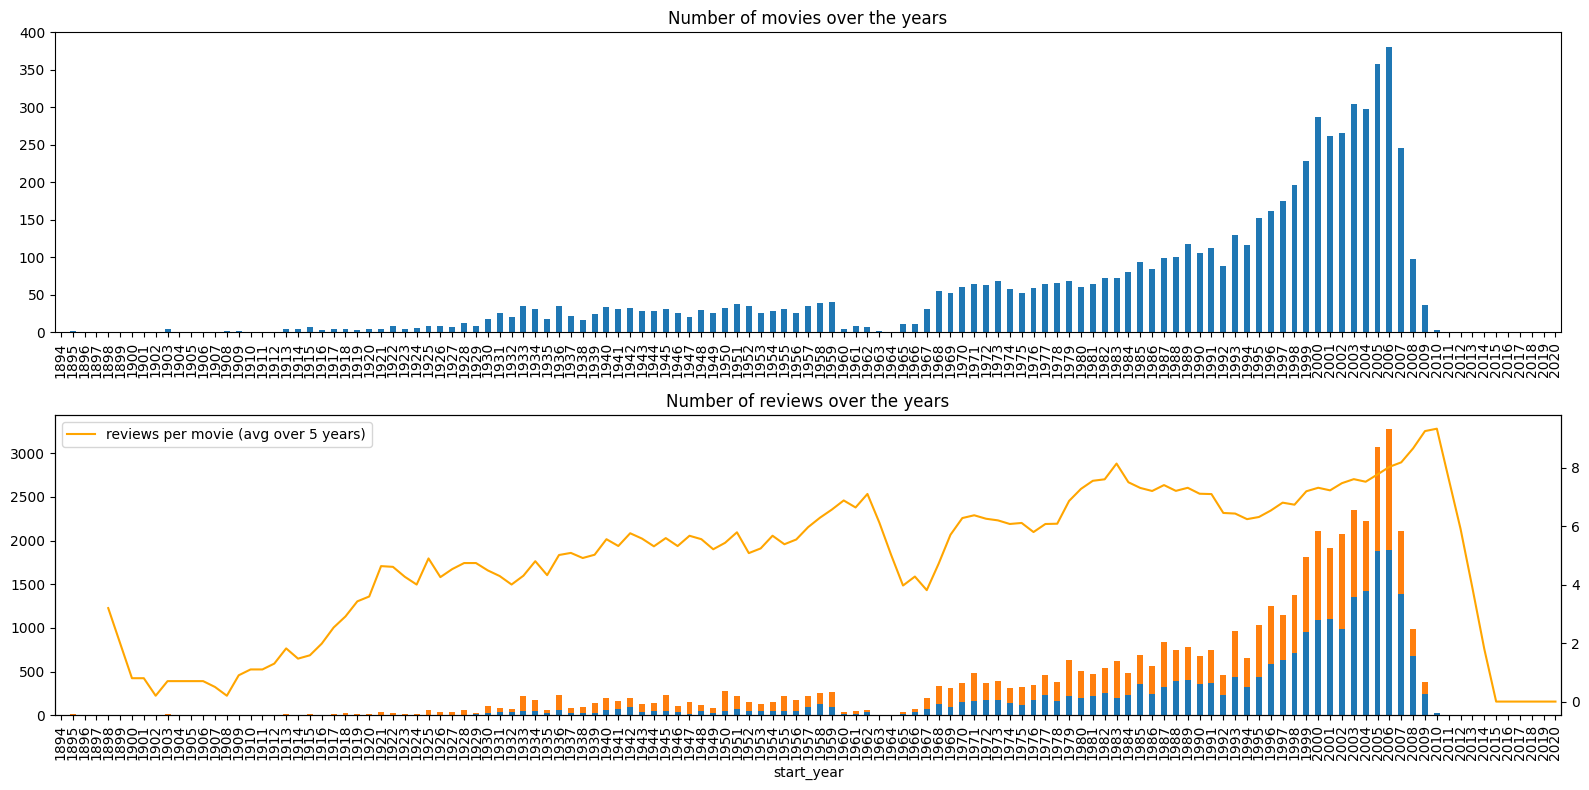

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of movies over the years')

ax = axs[1]

dft2 = df.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of reviews over the years')

fig.tight_layout()

Let's look at the distribution of the number of reviews per movie with the exact count and KDE (Kernel Density Estimation),just to know how it can differ from the exact count.

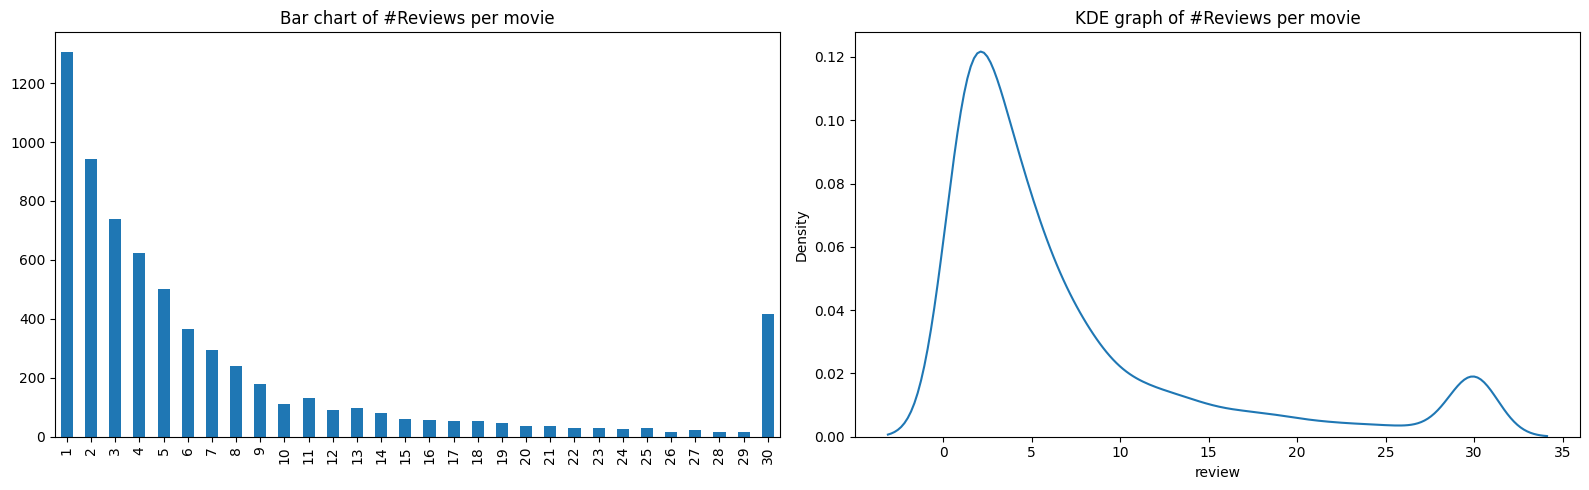

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar chart of #Reviews per movie')

ax = axs[1]
dft = df.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE graph of #Reviews per movie')

fig.tight_layout()

In [8]:
df['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

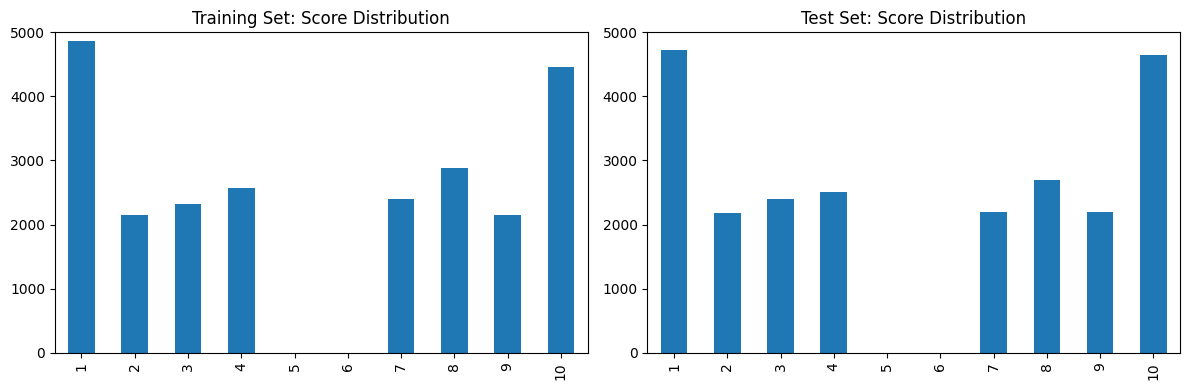

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Training Set: Score Distribution')

ax = axs[1]
dft = df.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test Set: Score Distribution')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the data set:

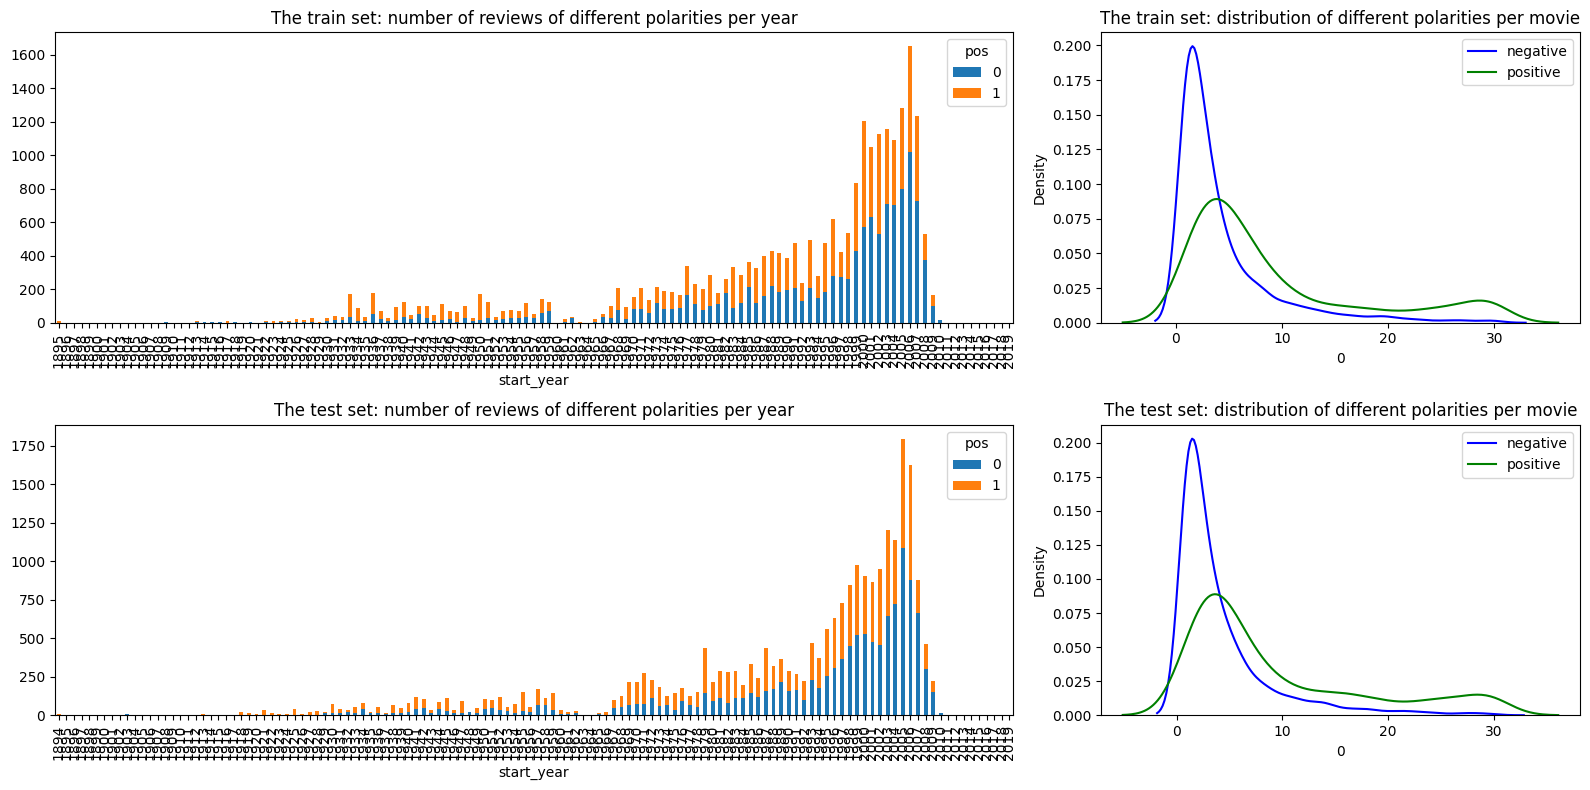

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Normalization

We assume all models below accepts texts in lowercase and without any punctuations marks, digits etc.

In [11]:
def clear_text(text):
    pattern = r"[^a-zA-Zñ']"
    text = re.sub(pattern, " ", text).lower()
    stop_words = set(nltk_stopwords.words("english"))
    list_words = text.split()
    filtered_words = [word for word in list_words if word not in stop_words]
    text = " ".join(filtered_words) 

    return text

In [12]:
df['review_norm'] = df.review.apply(clear_text)

In [13]:
df['review_norm']

0        pakage implies warren beatty goldie hawn pulli...
1        hell get made presenting caper comedy misbegot...
2        real story film seems like fly wall drama docu...
3        um serious film troubled teens singapore count...
4        i'm totally agree garryjohal singapore's comme...
                               ...                        
47326    another favorite columbos sports top notch cas...
47327    talk boring got expecting fascinating insight ...
47328    never thought i'd say biopic near abundance ch...
47329    spirit chaos artistic biopic miyazawa kenji ja...
47330    i'll make brief joy watch may may effective ch...
Name: review_norm, Length: 47331, dtype: object

In [ ]:
# corpus = df['review']

# def clear_text(text):
#     text = re.sub(r'[^a-zA-z\']', ' ', text)
#     text = text.split()
#     text = " ".join(text)
#     return text

# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# def lemmatize(text):
#     doc = nlp(text.lower())
#     lemmas = []
    
#     for token in doc:
#         lemmas.append(token.lemma_)
        
#     return ' '.join(lemmas)

# new_corpus = []

# for i in range(0, len(corpus)-1):
#     review = corpus[i]
#     new_text = lemmatize(clear_text(review))
#     new_corpus.append(new_text)

## Train / Test split

Fortunately, the entire data set is already divided into training/test parts; 'ds_part' is the related column.

In [15]:
df_train = df.query('ds_part == "train"').copy()
df_test = df.query('ds_part == "test"').copy()

train_target = df_train['pos']
test_target = df_test['pos']

print(df_train.shape)
print(df_test.shape)

(23796, 18)
(23535, 18)


In [16]:
X_train, X_test, Y_train, Y_test = df_train.drop(['pos'], axis=1), df_test.drop(['pos'], axis=1), train_target, test_target

## Working with models

### Model 0 - Constant